# Train PLTR Model
This notebook will develop and train a neural network to predict the percent change in the PLTR price.
It will utilize grid search to find the best hyperparameters

## Enviornment setups

In [1]:
# Import packages

# General Utility
from datetime import datetime
import datetime, time
from datetime import timedelta

# Data processing
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import RobustScaler

# Plotting
import matplotlib.pyplot as plt

import torch

# Diamond-Hands
import sys
sys.path.append('../Packages/')
import diamond_hands as dh

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ntnay\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
tickr = 'PLTR'

In [3]:
# Data Locations
processed_input_dir = '../../Data/ProcessedInputs/'
model_dir = '../../Data/Models/'
grid_result_dir = model_dir+tickr+'/'
fine_grid_result_dir = model_dir+tickr+'/Fine/'
pred_dir = '../../Data/Predictions/'
final_model_dir = '../../Data/Models/Final/'

In [4]:
TRAIN_ON_GPU, TRAIN_ON_MULTI_GPUS = dh.setupPytorch()

Training on GPU!


In [5]:
with open(processed_input_dir+tickr+'_input_data.bin','rb') as f:
    df = pickle.load(f)
with open(processed_input_dir+tickr+'_output_data.bin','rb') as f:
    output_data = pickle.load(f)
with open(model_dir+tickr+'_scaler.bin','rb') as f:
    scaler = pickle.load(f)

In [6]:
df = df[:-1]

In [7]:
df['2021-03-01':]

,P_Change,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,...,Tomorrow_Tickr_#Pos,Tomorrow_Tickr_W#Neg,Tomorrow_Tickr_W#Neu,Tomorrow_Tickr_W#Pos,Tomorrow_Tickr_%Neg,Tomorrow_Tickr_%Neu,Tomorrow_Tickr_%Pos,Tomorrow_Tickr_W%Neg,Tomorrow_Tickr_W%Neu,Tomorrow_Tickr_W%Pos
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,-0.046343,-1.982905,-1.748931,-0.626554,-1.335460,-1.246074,0.653053,-1.652094,0.346409,-0.325855,...,0.290123,0.296128,0.324506,0.290190,0.495470,0.106595,-0.083833,0.142057,0.218088,0.095456
2021-03-02,0.051107,-2.215258,-1.957911,-0.678369,-1.258228,-1.365641,-0.203331,-1.609359,0.253640,-0.456827,...,0.475309,0.107062,0.607607,0.839242,-0.612969,0.661093,0.176199,-0.454792,0.178207,0.713598
2021-03-03,-0.019868,-2.510143,-2.175442,-0.692796,-1.333867,-1.369203,-0.426809,-1.508300,-0.565779,-0.456827,...,1.580247,2.665148,2.773231,2.718054,0.187736,0.032453,0.231145,0.287823,0.272580,0.092994
2021-03-04,-0.212459,-2.253614,-1.719526,-0.557634,-0.586921,-1.142544,-0.034716,-0.939227,0.627695,-0.456827,...,0.104938,-0.070615,0.424651,0.219291,-0.433998,0.319987,0.402002,-0.504349,0.792569,-0.043605
2021-03-05,-0.273877,-1.702194,-2.210792,-0.376069,-0.974205,-1.183344,-1.374883,-0.863632,0.262793,-0.456827,...,0.043210,0.214123,0.805489,0.221764,-0.464686,1.567679,-0.902555,-0.253764,1.067812,-0.690024
2021-03-08,-0.167286,-2.097051,-2.477840,-0.495497,-1.304675,-0.973601,0.636620,-0.533401,-1.563933,-1.036934,...,0.277778,0.391800,0.339913,0.415499,-0.129037,0.006386,0.501883,0.226601,0.064606,0.318277
2021-03-09,1.019418,-1.903026,-2.196205,-0.362545,-0.595698,-0.759047,0.157721,-0.472246,0.228063,-1.036934,...,-0.129630,-0.195900,0.012037,-0.093982,-0.258844,0.240246,0.352524,-0.444600,0.603786,0.001563
2021-03-10,0.558038,-2.151991,-1.903940,-0.460811,-0.382696,-0.382783,0.663518,-0.311583,1.278962,-1.036934,...,-0.117284,-0.166287,0.116996,-0.097279,-0.128434,0.628589,-0.160880,-0.445114,0.834013,-0.343433
2021-03-11,-0.053844,-1.823315,-1.664277,-0.343235,0.176918,-0.692248,0.353734,-0.366744,1.154508,-0.306081,...,0.043210,-0.070615,0.177660,0.276175,-0.461491,0.155758,0.597904,-0.392499,0.220403,0.649450


In [8]:
n_test=37

## Grid Search

In [10]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [1,5,10,20,40,60]
n_hidden = [10,50,100]
n_layers = [2,3]
drop_prob = [0.1,0.25,0.5]
lr = [0.001,0.01]
clip = [1,5,10]
batch_size = [100]

In [11]:
# use grid search to optimize hyperparameters
grid_result = []
dh.gridSearch(grid_results = grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=10,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 648 different configurations.
Iteration: 1 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 2 |periods: 5|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 3 |periods: 10|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 4 |periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 5 |periods: 40|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 6 |periods: 60|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 7 |periods: 1|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 8 |periods: 5|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 9 |periods: 10|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 10 |periods: 20

Training complete in 0m 0s
Iteration: 81 |periods: 10|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 82 |periods: 20|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 83 |periods: 40|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 84 |periods: 60|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 85 |periods: 1|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 86 |periods: 5|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 87 |periods: 10|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 88 |periods: 20|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 89 |periods: 40|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 0s
Iteration: 90 |periods: 60|hidden: 100|laye

Iteration: 161 |periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 0s
Iteration: 162 |periods: 60|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 0s
Iteration: 163 |periods: 1|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 0s
Iteration: 164 |periods: 5|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 0s
Iteration: 165 |periods: 10|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 0s
Iteration: 166 |periods: 20|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 0s
Iteration: 167 |periods: 40|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 0s
Iteration: 168 |periods: 60|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 0s
Iteration: 169 |periods: 1|hidden: 50|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 0s
Iteration: 170 |periods: 5|hidden: 50|layers: 3|drop: 0.25|lr: 0.

Training complete in 0m 0s
Iteration: 241 |periods: 1|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 0s
Iteration: 242 |periods: 5|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 0s
Iteration: 243 |periods: 10|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 0s
Iteration: 244 |periods: 20|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 0s
Iteration: 245 |periods: 40|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 0s
Iteration: 246 |periods: 60|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 0s
Iteration: 247 |periods: 1|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 0s
Iteration: 248 |periods: 5|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 0s
Iteration: 249 |periods: 10|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 0s
Iteration: 250 |periods: 20|hidden: 10

Training complete in 0m 0s
Iteration: 320 |periods: 5|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 0s
Iteration: 321 |periods: 10|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 0s
Iteration: 322 |periods: 20|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 0s
Iteration: 323 |periods: 40|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 0s
Iteration: 324 |periods: 60|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 0s
Iteration: 325 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 0s
Iteration: 326 |periods: 5|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 0s
Iteration: 327 |periods: 10|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 0s
Iteration: 328 |periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 0s
Iteration: 329 |periods: 40|hidden: 10|

Training complete in 0m 0s
Iteration: 400 |periods: 20|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 0s
Iteration: 401 |periods: 40|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 0s
Iteration: 402 |periods: 60|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 0s
Iteration: 403 |periods: 1|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 0s
Iteration: 404 |periods: 5|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 0s
Iteration: 405 |periods: 10|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 0s
Iteration: 406 |periods: 20|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 0s
Iteration: 407 |periods: 40|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 0s
Iteration: 408 |periods: 60|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 0s
Iteration: 409 |periods: 1|hidden: 100|layers: 2

Iteration: 479 |periods: 40|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 0s
Iteration: 480 |periods: 60|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 0s
Iteration: 481 |periods: 1|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 0s
Iteration: 482 |periods: 5|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 0s
Iteration: 483 |periods: 10|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 0s
Iteration: 484 |periods: 20|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 0s
Iteration: 485 |periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 0s
Iteration: 486 |periods: 60|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 0s
Iteration: 487 |periods: 1|hidden: 10|layers: 3|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 0s
Iteration: 488 |periods: 5|hidden: 10|layer

Iteration: 557 |periods: 40|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 558 |periods: 60|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 559 |periods: 1|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 560 |periods: 5|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 561 |periods: 10|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 562 |periods: 20|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 563 |periods: 40|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 564 |periods: 60|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 565 |periods: 1|hidden: 50|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 566 |periods: 5|hidden: 50|layers: 3|drop: 0.1|lr: 0.0

Iteration: 636 |periods: 60|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 637 |periods: 1|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 638 |periods: 5|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 639 |periods: 10|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 640 |periods: 20|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 641 |periods: 40|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 642 |periods: 60|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 643 |periods: 1|hidden: 100|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 644 |periods: 5|hidden: 100|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 645 |periods: 10|hidden: 100|layers: 3|drop: 0.5|lr: 0.

In [12]:
with open(model_dir+tickr+'_grid_search_result.bin','wb') as f:
    pickle.dump(grid_result,f)

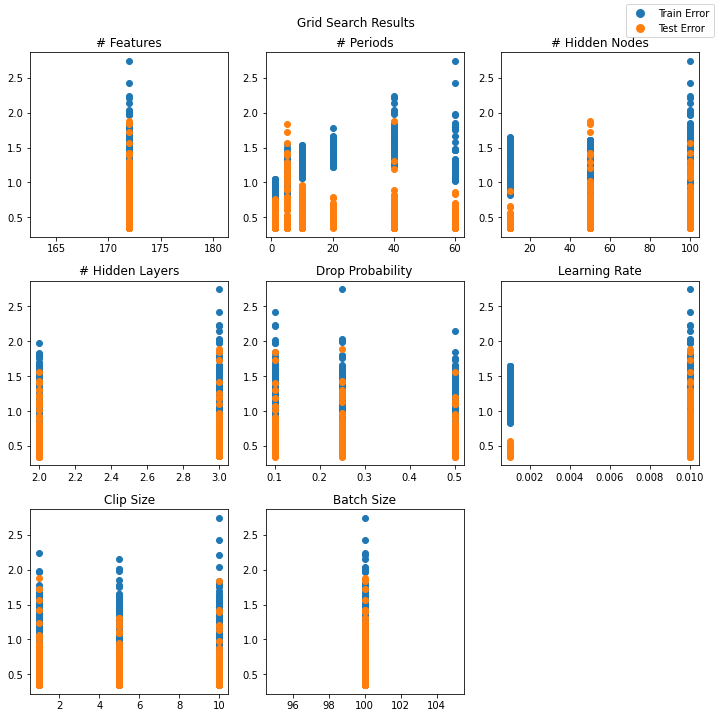

In [13]:
dh.visualizeGridSearch(grid_result)

In [26]:
resultdf = dh.resultDF(grid_result)

In [27]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size
540,0.861403,0.340044,172.0,1.0,10.0,2.0,0.10,0.010,10.0,100.0
508,1.623978,0.343233,172.0,40.0,10.0,2.0,0.50,0.001,10.0,100.0
184,1.549445,0.345433,172.0,40.0,10.0,2.0,0.50,0.010,1.0,100.0
576,0.888856,0.346339,172.0,1.0,10.0,2.0,0.25,0.010,10.0,100.0
470,1.503897,0.348713,172.0,10.0,10.0,2.0,0.25,0.001,10.0,100.0
...,...,...,...,...,...,...,...,...,...,...
583,1.045048,1.427005,172.0,5.0,50.0,2.0,0.25,0.010,10.0,100.0
193,1.003922,1.564468,172.0,5.0,100.0,2.0,0.50,0.010,1.0,100.0
133,1.038067,1.724405,172.0,5.0,50.0,3.0,0.10,0.010,1.0,100.0
565,1.043076,1.839358,172.0,5.0,50.0,3.0,0.10,0.010,10.0,100.0


## Fine Grid Search

In [28]:
best_model_id = sorted_results.index[0]

540

In [29]:
with open(grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
    model = torch.load(f)
model.eval()


StockLSTM(
  (lstm): LSTM(172, 10, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [30]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [model.n_periods]
n_hidden = [model.n_hidden]
n_layers = [model.n_layers]
drop_prob = [model.drop_prob]
lr = [model.lr]
clip = [model.clip]
batch_size = [1,5,10,20,40,60,120,240]
epochs = [10,25,50,100,250,500]

In [31]:
# use fine grid search to optimize hyperparameters
fine_grid_result = []
dh.finegridSearch(grid_results = fine_grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=epochs,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=fine_grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 48 different configurations.
Iteration: 1 |epochs: 10|periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 3s
Iteration: 2 |epochs: 10|periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 1s
Iteration: 3 |epochs: 10|periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 4 |epochs: 10|periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 5 |epochs: 10|periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 6 |epochs: 10|periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 7 |epochs: 10|periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 8 |epochs: 10|periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 0s
Iteration: 9 |epochs: 25|periods: 1|hidden: 1

In [32]:
with open(model_dir+tickr+'fine_grid_search_result.bin','wb') as f:
    pickle.dump(fine_grid_result,f)

NameError: name 'train_error' is not defined

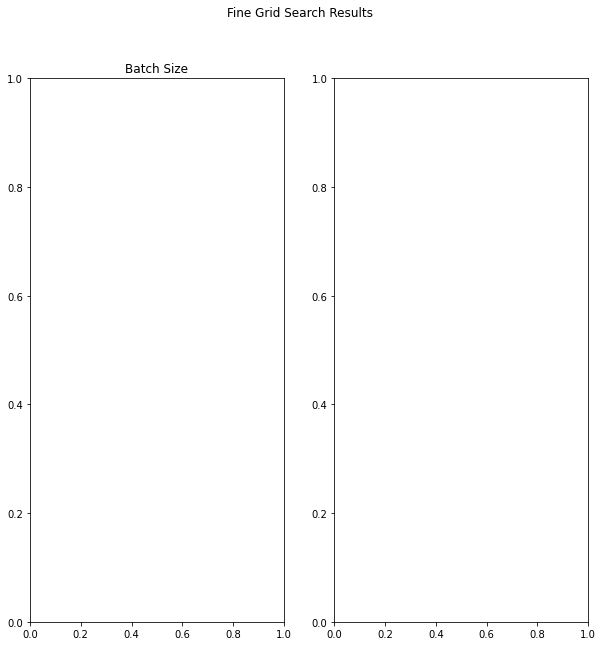

In [21]:
dh.visualizeFineGridSearch(fine_grid_result)

In [33]:
resultdf = dh.resultDFFine(fine_grid_result)

In [34]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size,Epochs
7,1.326164,0.381182,172.0,1.0,10.0,2.0,0.1,0.01,10.0,240.0,10.0
6,1.265190,0.399775,172.0,1.0,10.0,2.0,0.1,0.01,10.0,120.0,10.0
5,1.285813,0.418160,172.0,1.0,10.0,2.0,0.1,0.01,10.0,60.0,10.0
11,0.654124,0.438034,172.0,1.0,10.0,2.0,0.1,0.01,10.0,20.0,25.0
32,0.531731,0.466859,172.0,1.0,10.0,2.0,0.1,0.01,10.0,1.0,250.0
15,1.080403,0.474534,172.0,1.0,10.0,2.0,0.1,0.01,10.0,240.0,25.0
4,1.209959,0.487302,172.0,1.0,10.0,2.0,0.1,0.01,10.0,40.0,10.0
14,1.149055,0.509996,172.0,1.0,10.0,2.0,0.1,0.01,10.0,120.0,25.0
33,0.444323,0.522586,172.0,1.0,10.0,2.0,0.1,0.01,10.0,5.0,250.0
1,0.977810,0.530407,172.0,1.0,10.0,2.0,0.1,0.01,10.0,5.0,10.0


## Evaluate Final Model

In [9]:
#best_model_id = sorted_results.index[0]
#with open(fine_grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
#    model = torch.load(f)
#model.eval()
with open(grid_result_dir+str(541)+'.model','rb') as f:
    model = torch.load(f)
model.eval()

StockLSTM(
  (lstm): LSTM(172, 10, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

Training RMSE: 1.9075971211291782
Test RMSE: 1.0058821815094037
Training MAE: 1.2049767901363426
Test MAE: 0.8206324042145571
Training - Above Error: $1.49 (41.58%) Below Error: $-1.00 (58.42%)
Test - Above Error: $0.82 (40.54%) Below Error: $-0.82 (59.46%)


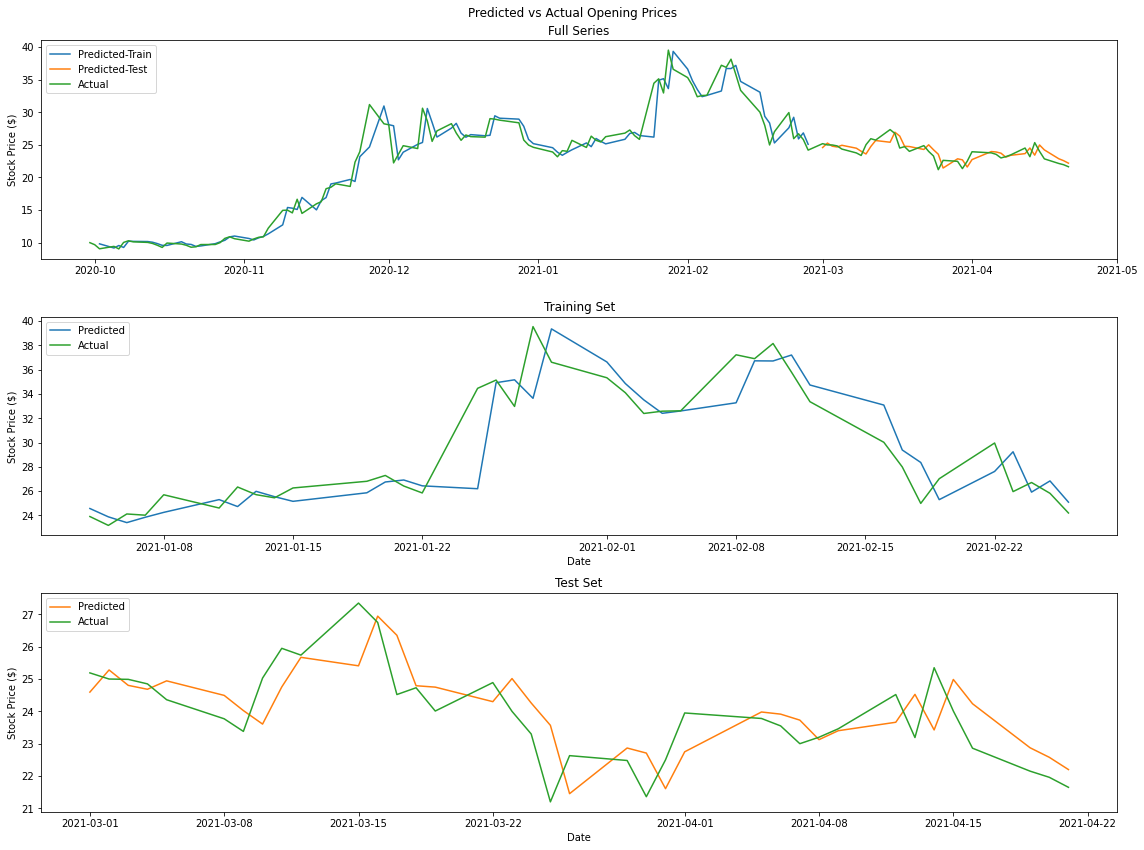

In [10]:
preds = dh.evaluateModel(model=model,
             input_data=df,
             output_data=output_data[:-1],
             scaler=scaler,
             n_steps_in=model.n_periods,
             n_steps_out=1,
             n_test=n_test)

In [11]:
preds.tail()

,Open,Raw_Predictions,Prediction_Type,Predicted
Date,,,,
2021-04-15,24.010000,0.009405,Test,24.986885
2021-04-16,22.860001,0.000585,Test,24.235806
2021-04-19,22.150000,0.019356,Test,22.873365
2021-04-20,21.959999,0.010881,Test,22.578744
2021-04-21,21.650000,0.009873,Test,22.198946


In [12]:
with open(pred_dir+tickr+'_pred.bin','wb') as f:
    pickle.dump(preds,f)

In [13]:
with open(final_model_dir+tickr+'_model.model','wb') as f:
    torch.save(model,f)